In [5]:
import numpy as np
import cv2
from keras import backend as K
from keras.layers import Input, Dense, Flatten, Dropout, Concatenate
from keras.models import Model
import keras
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import load_img,img_to_array
from keras.optimizers import Adam,SGD
from numpy import genfromtxt
from keras.models import load_model

from keras import regularizers

In [8]:
def create_model():
    base_model = keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False)
  
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
 
    x = Dense(1024, activation='relu')(x)  
    predictions = Dense(2, activation='softmax')(x)


    model = Model(input=base_model.input, output=predictions)

    for layer in base_model.layers:
        layer.trainable = False

   
 
    model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])


    return model   
model=create_model()

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, None, None, 3 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, None, None, 3 0           batch_normalization_283[0][0]    
__________________________________________________________________________________________________
conv2d_284

c:\users\dome\appdata\local\conda\conda\envs\envp36\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [16]:
# Read CSV annotations
anns = genfromtxt('anns/'+'anns_full.csv', delimiter=',',dtype=str)
np.random.shuffle(anns)
# usage custom_gen(range(0,3000+1))
def custom_gen(use_range,batch_size = 1):
    while True:
        image_data = []
        label_data_gender = []
        label_data_age = []
        start_indx = np.random.randint(low=use_range[0],high=use_range[-batch_size])
        
        # Read anns
        batch_row = anns[start_indx:start_indx+batch_size]       
                    
        
        # Read images
        for row in batch_row:
            im = load_img('images/'+row[0]+'/'+row[2]+'.'+row[1],target_size=(256, 256))  #PIL Image          
            im = img_to_array(im) # Numpy
            im = im/255.
            image_data.append(im)               
            
            label_data_gender.append(np.fromstring(row[5], sep=' ')) # target gender
            label_data_age.append(np.fromstring(row[6], sep=' ')) # target gender
            
   
        image_data = np.array(image_data)
        label_data_gender = np.array(label_data_gender)
        label_data_age = np.array(label_data_age)
        
        yield( image_data, label_data_gender )       
        

In [43]:
train_ratio = 0.85
use_dataset = 11333
num_train = round(use_dataset*train_ratio)
train_range = range(0,num_train+1)
val_range = range(num_train+1,use_dataset+1)

print('all : ',len(anns),'\nuse :',use_dataset,'\ntrain_range : ',train_range[0],'-',train_range[-1],\
      '\nval_range',val_range[0],'-',val_range[-1])
batch_size = 1

all :  11333 
use : 11333 
train_range :  0 - 9633 
val_range 9634 - 11333


In [44]:
model.fit_generator(
        custom_gen(train_range), 
        steps_per_epoch=max(1, len(train_range)//batch_size),
        epochs=1,        
        validation_data=custom_gen(val_range),
        validation_steps=max(1, len(val_range)//batch_size),)

Epoch 1/1
9634/9634 [==============================] - 361s 37ms/step - loss: 0.6941 - acc: 0.5050 - val_loss: 0.6900 - val_acc: 0.5276


[[0.51599807 0.48400193]]


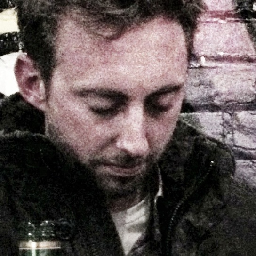

In [57]:
rand_indx = np.random.randint(low=0,high=len(anns))
rowp = anns[rand_indx]
im_ori = load_img('images/'+rowp[0]+'/'+rowp[2]+'.'+rowp[1],target_size=(256, 256))

im = img_to_array(im_ori)
im = im/255.
im = np.expand_dims(im, axis=0)

print(model.predict(im ,verbose = 0))

im_ori

In [109]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [110]:
reset_weights(model)

In [ ]:
print (model.get_weights())

In [ ]:
model.save('my_model.h5')

(1, 256, 256, 3)